# README.

This notebook's intent and purpose is allowing data scientists to rate measures. Rated measures are the basis for training Neural Networks.

Important: Before git-committing clear all outputs.

In [1]:
!cp /whhdata/dbconnection.json .

In [2]:
%matplotlib inline
import sys
sys.path.insert(0, "..")
import dbutils
from cgmcore import utils
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from time import mktime
import calendar
import time
import numpy as np
from IPython.display import display
import random
import math
from PIL import Image
from tqdm import tqdm, trange
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import HBox, Output
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import getpass

# Constants.
measure_keys = ["height", "weight", "age", "muac", "head_circumference"]
status_values = ["standing", "lying", "mixed", "rejected", "delete"]

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Filter measures by STD and render.

The following cells filter all measures by the standard deviation of all measures. This helps to detect and remove outliers.

## Tests.

- All cells run without error.
- The expected outcome would be a couple of scatter plots showing the distribution of the targets.

In [3]:
main_connector = dbutils.connect_to_main_database()

def select_measures_in_std_range(std_factor=None):

    sql_statement = ""
    
    # Create temporary table for average and STD.
    if std_factor != None:
        sql_statement += "WITH AvgStd AS (" + "\n"
        sql_statement += "  SELECT" + "\n"
        fields = []
        for key in measure_keys:
            fields.append("AVG({}) AS {}_avg".format(key, key))
            fields.append("STDDEV({}) AS {}_stddev".format(key, key))
        sql_statement += "    " + ",\n    ".join(fields) + "\n"
        sql_statement += "  FROM measure WHERE type='manual'" + "\n"
        sql_statement += ")" + "\n"

    # Select all fields.
    fields = ["measure.id", "qr_code", "measure.timestamp"]
    fields.extend(measure_keys)
    fields = ", ".join(fields)
    sql_statement += "SELECT {} FROM measure".format(fields) + "\n"
    sql_statement += " INNER JOIN person ON measure.person_id = person.id" + "\n"
    
    # Use temporary table.
    if std_factor != None:
        sql_statement += " CROSS JOIN AvgStd" + "\n"
    
    # Allow only manual measurements.
    sql_statement += " WHERE type='manual'" + "\n"
    
    # Filter my mean and STD.
    if std_factor != None:
        for key in measure_keys:
            sql_statement += " AND ABS({} - {}_avg) / {}_stddev < {}".format(key, key, key, std_factor) + "\n"

    # Done.
    sql_statement += ";"

    # Retrieve all scans from database.
    results = main_connector.execute(sql_statement, fetch_all=True)
    results = np.array(results)
    print("Found {} scans for STD factor {}.".format(len(results), std_factor))
    return results

Found 7028 scans for STD factor None.
Found 6927 scans for STD factor 2.0.
Found 6872 scans for STD factor 1.5.
Found 5741 scans for STD factor 1.0.
Found 4150 scans for STD factor 0.75.


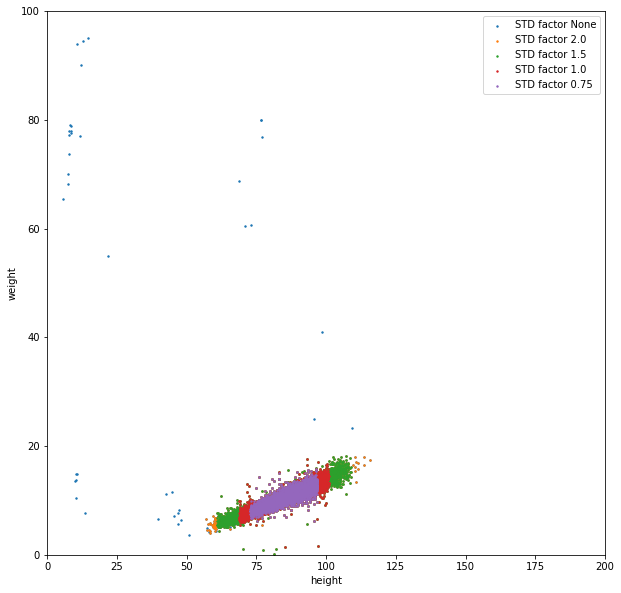

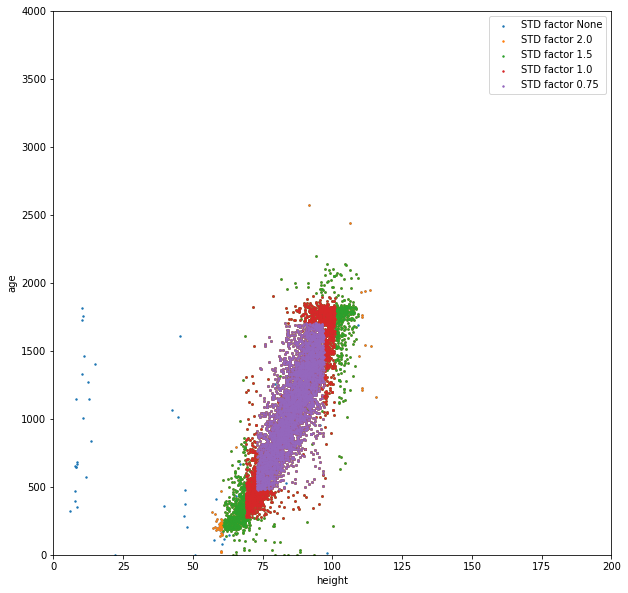

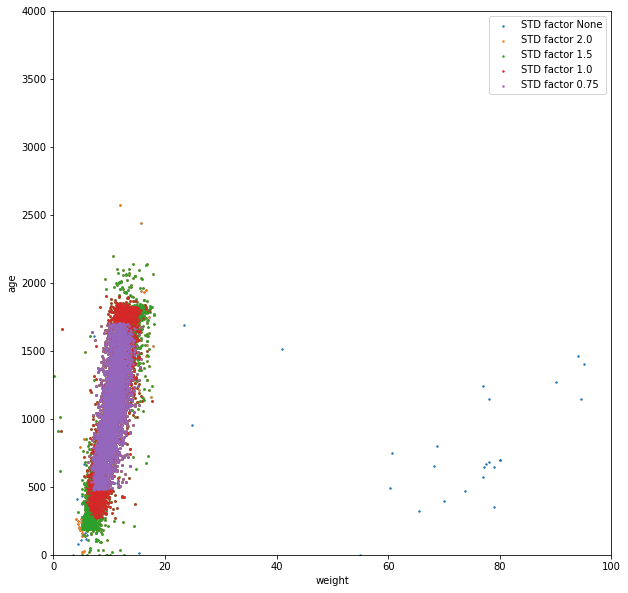

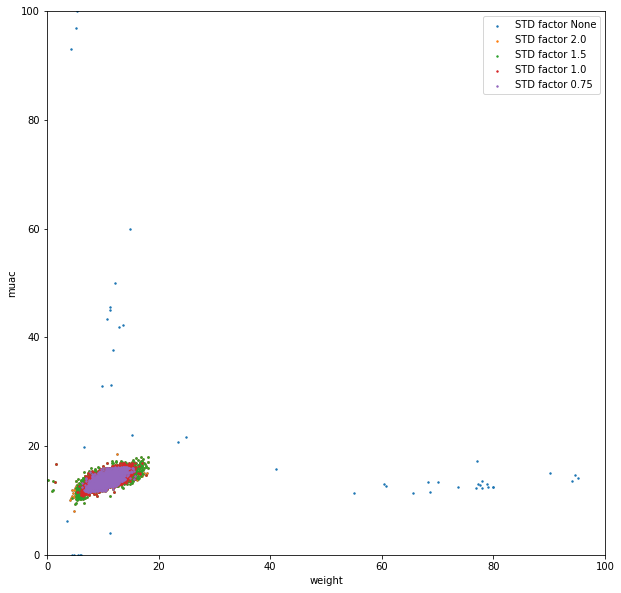

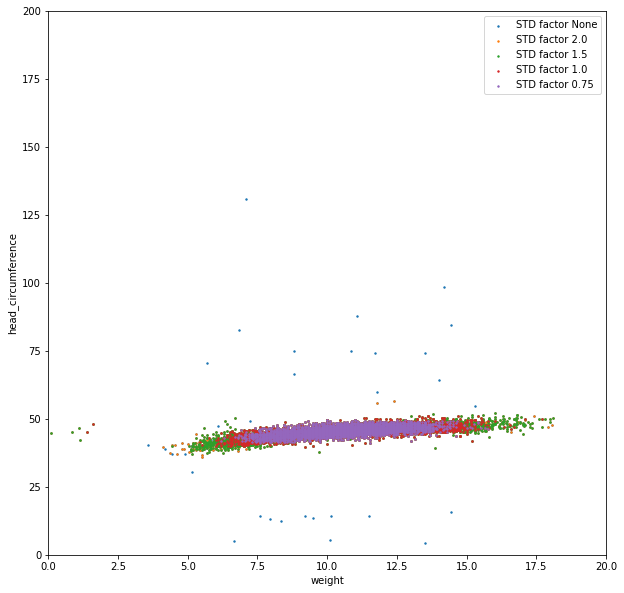

In [4]:
# Select measures with multiple STD ranges.
overall_results = []
for std_factor in [None, 2.0, 1.5, 1.0, 0.75]:
    results = select_measures_in_std_range(std_factor=std_factor)
    overall_results.append((std_factor, results))
    
# For rendering a scatterplot.
def render_for_keys(key1, key2, xlim, ylim):

    # Indices of the keys.
    index1 = measure_keys.index(key1)
    index2 = measure_keys.index(key2)

    # Prepare plot.
    plt.figure(figsize=(10, 10))
    plt.xlabel(key1)
    plt.ylabel(key2)
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Render.
    for std_factor, all_scans in overall_results:
        # QR-codes and timestamp.
        all_scans_head = all_scans[:,:3]

        # Actual measurements. All numbers.
        all_scans_tail = all_scans[:,3:].astype("float32")

        # Render.
        plt.scatter(all_scans_tail[:,index1], all_scans_tail[:,index2], s=2, label="STD factor {}".format(std_factor))

    # Done.
    plt.legend()
    plt.show()
    plt.close()

# Render all.
render_parameters = []
render_parameters.append(("height", "weight", (0, 200), (0, 100)))
render_parameters.append(("height", "age", (0, 200), (0, 4000)))
render_parameters.append(("weight", "age", (0, 100), (0, 4000)))
render_parameters.append(("weight", "muac", (0, 100), (0, 100)))
render_parameters.append(("weight", "head_circumference", (0, 20), (0,200)))
for key1, key2, xlim, ylim in render_parameters:
    render_for_keys(key1, key2, xlim, ylim)

# Interactive cell for accepting/rejecting scans.

Now comes the good part... The following cells allow you to actually rate/sort measures.

## Tests.

- All cells run without error.
- Expected outcome: After some processing, the last cell shows a thumbnail-gallery of a random scan plus a couple of buttons for rating.
- Expected outcome: After clicking one of the buttons (except skip) there should be a new entry in the database, table measure_quality.

In [5]:
# Get all scans in a given STD range.
all_scans = select_measures_in_std_range(std_factor=2.0)

# QR-codes and timestamp.
all_scans_head = all_scans[:,:3]

# Actual measurements. All numbers.
all_scans_tail = all_scans[:,3:].astype("float32")

Found 6927 scans for STD factor 2.0.


Counting artifacts for f2467a1fb0c542b9_measure_1536901904936_iTyYV0ICocjByjlX SAM-SNG-097 1536901904936...
Already in database. Skipped.
Counting artifacts for 3a41dcc03896bc3b_measure_1543990873042_nnzXuoe4skxSCan7 MP_WHH_1454 1543990873042...
Already in database. Skipped.
Counting artifacts for 42c59856328d2eef_measure_1552028297264_dZfUNQWKgAsOBr8h RJ_WHH_1860 1552028297264...
Found 0 JPGs for QR-code RJ_WHH_1860 and timestamp 1552028297264.
Counting artifacts for 75124f2bd583772_measure_1539017201450_gNCbyyqMUpburrCm RJ_WHH_1313 1539017201451...
Found 0 JPGs for QR-code RJ_WHH_1313 and timestamp 1539017201451.
Counting artifacts for fb3bfc1a748e12ee_measure_1539158022042_xyqy2ND6szhnN3jj MP_WHH_0281 1539158022043...
Found 76 JPGs for QR-code MP_WHH_0281 and timestamp 1539158022043.


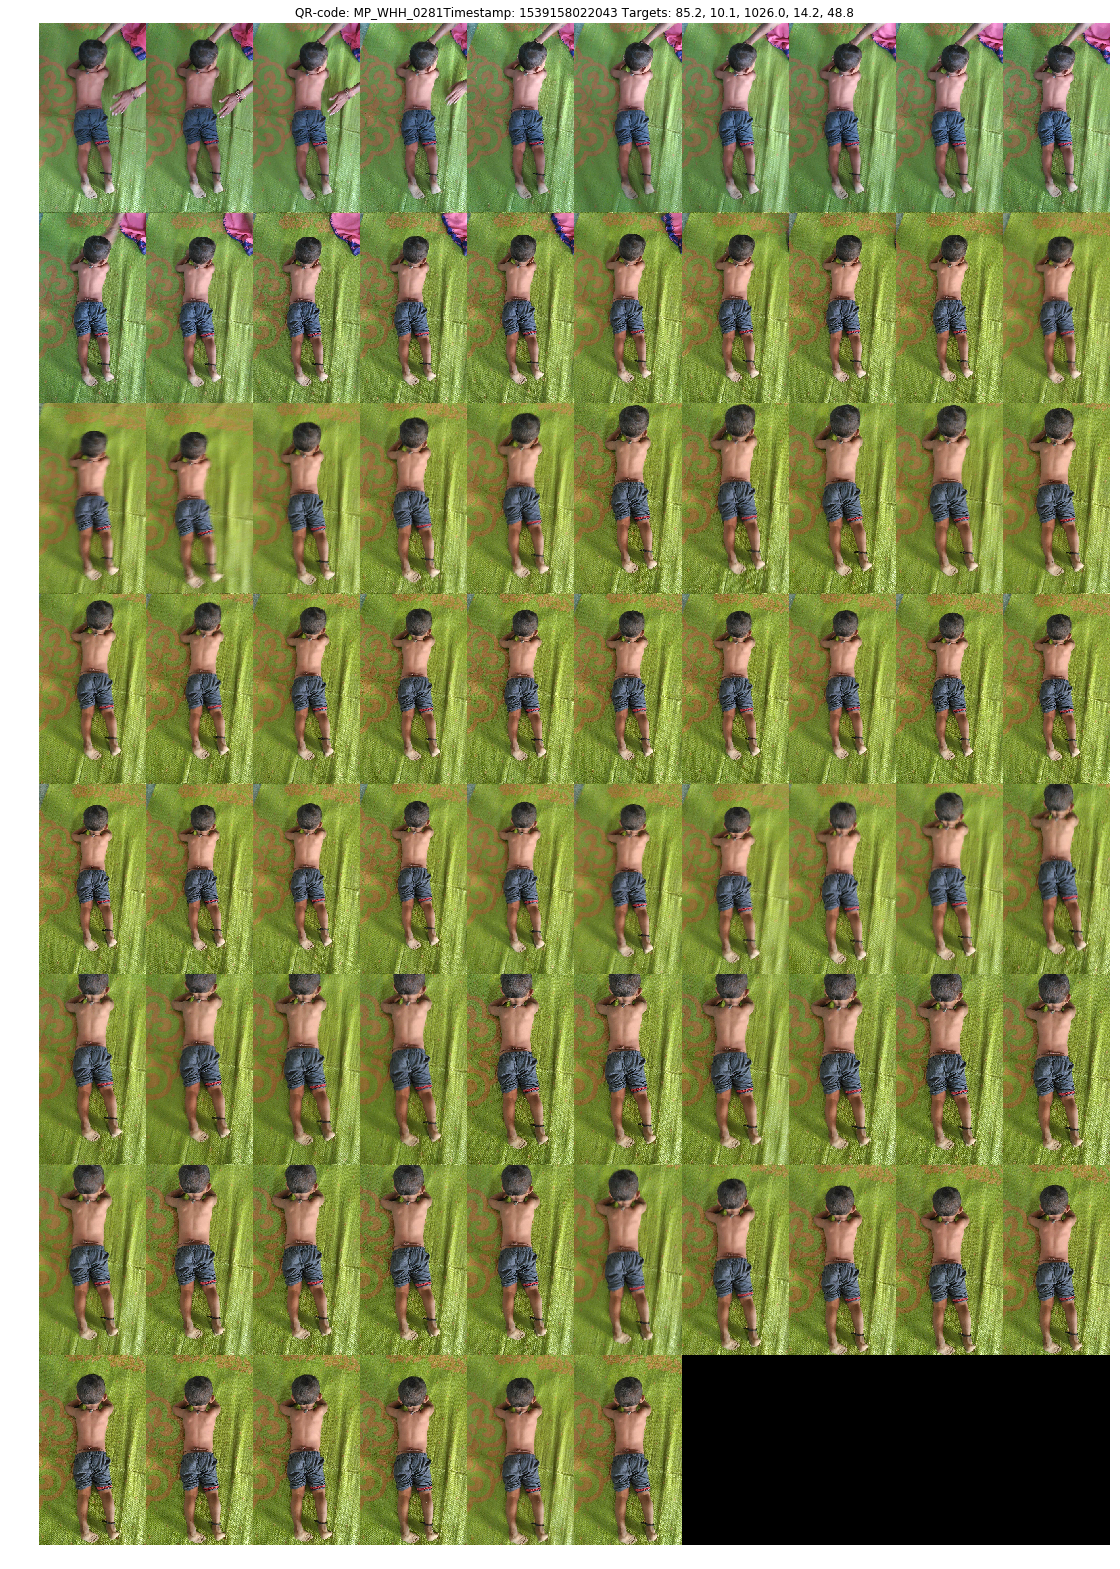

In [6]:
measure_id = None
measure_targets = None

# Runs the whole thing.
def clear_and_display():
    clear_output()
    artifacts, targets, qr_code, timestamp = select_artifacts()
    utils.render_artifacts_as_gallery(artifacts, targets, qr_code, timestamp, 10)
    display(HBox([standing_button, lying_button, mixed_button, reject_button, delete_button, skip_button]))
    
# Select a random thingy.
def select_artifacts():
    artifacts = []
    while len(artifacts) ==  0:
        
        # Randomly select an artifact.
        global measure_id
        global measure_targets
        index = random.randint(0, len(all_scans))
        measure_id, qr_code, timestamp = all_scans_head[index]
        targets = all_scans_tail[index]
        print("Counting artifacts for {} {} {}...".format(measure_id, qr_code, timestamp))
        
        # Check if measure is already in database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM measure_quality mq "
        sql_statement += " WHERE mq.measure_id='{}'".format(measure_id)
        sql_statement += " AND mq.key='expert_status'"
        sql_statement += ";"
        results = main_connector.execute(sql_statement, fetch_one=True)[0]
        if results != 0:
            print("Already in database. Skipped.")
            continue
        
        # Select all JPGs for that measure-id.
        def select_jpgs(qr_code, timestamp):
            
            sql_statement = ""
            sql_statement += "SELECT path FROM artifact AS a "
            sql_statement += " WHERE a.measure_id='{}'".format(measure_id)
            sql_statement += " AND a.type='rgb'"
            sql_statement += ";"

            results = main_connector.execute(sql_statement, fetch_all=True)
            results = np.array(results)
            print("Found {} JPGs for QR-code {} and timestamp {}.".format(len(results), qr_code, timestamp))
            return results
        artifacts = select_jpgs(qr_code, timestamp)
    return artifacts, targets, qr_code, timestamp


# Standing button.
standing_button = widgets.Button(description="Standing")
def on_standing_button_clicked(_):
    insert_status_into_database(measure_id, status="standing")
    clear_and_display()
standing_button.on_click(on_standing_button_clicked)

# Lying button.
lying_button = widgets.Button(description="Lying")
def on_lying_button_clicked(_):
    insert_status_into_database(measure_id, status="lying")
    clear_and_display()
lying_button.on_click(on_lying_button_clicked)

# Mixed button.
mixed_button = widgets.Button(description="Mixed")
def on_mixed_button_clicked(_):
    insert_status_into_database(measure_id, status="mixed")
    clear_and_display()
mixed_button.on_click(on_mixed_button_clicked)

# Reject button.
reject_button = widgets.Button(description="Reject")
def on_reject_button_clicked(_):
    insert_status_into_database(measure_id, status="rejected")
    clear_and_display()
reject_button.on_click(on_reject_button_clicked)

# Delete button.
delete_button = widgets.Button(description="Delete")
def on_delete_button_clicked(_):
    insert_status_into_database(measure_id, status="delete")
    clear_and_display()
delete_button.on_click(on_delete_button_clicked)

# Delete button.
skip_button = widgets.Button(description="Skip")
def on_skip_button_clicked(_):
    clear_and_display()
skip_button.on_click(on_skip_button_clicked)

# Update database.
def insert_status_into_database(measure_id, status):
    created_by = getpass.getuser()
    sql_statement = ""
    sql_statement += "INSERT INTO measure_quality"
    sql_statement += " (type, key, text_value, created_by, measure_id)"
    sql_statement += " VALUES ('{}', '{}', '{}', '{}', '{}');".format("?", "expert_status", status, created_by, measure_id)
    main_connector.execute(sql_statement)
    

# Initial render.
clear_and_display()

# Target.

If a user-story requires a specific number of rated measures, this can be checked here.

## Tests.

- All cells run without error.
- Expected outcome: A pie chart telling how many measures have been rated and how many still need to be rated.

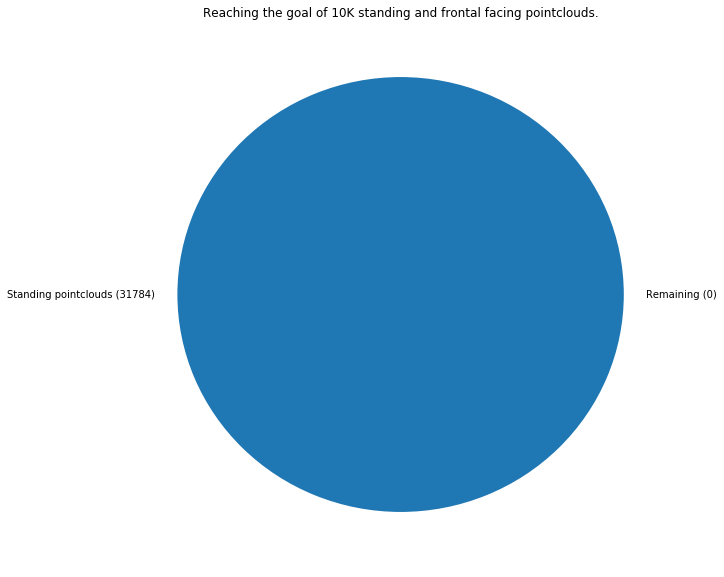

In [8]:
main_connector = dbutils.connect_to_main_database()

# This is the goal.
required_number_of_rated_measures = 10000

# For the chart.
chart_data = []
chart_labels = []

# Getting the number of rated measures.
sql_statement = ""
sql_statement += "SELECT COUNT(*) FROM measure_quality mq"
sql_statement += " INNER JOIN artifact a ON mq.measure_id = a.measure_id"
sql_statement += " WHERE mq.key='expert_status' AND mq.text_value='standing'"
sql_statement += " AND a.type='pcd'"
sql_statement += " AND (POSITION('_100_' in a.path) > 0 OR POSITION('_104_' in a.path) > 0)"
sql_statement += ";"
result = main_connector.execute(sql_statement, fetch_one=True)[0]
chart_data.append(result)
chart_labels.append("Standing pointclouds ({})".format(result))

# Getting the number of remaining measures. Can be zero if goal is met.
result = np.max([0, 10000 - result])
chart_data.append(result)
chart_labels.append("Remaining ({})".format(result))
    
# Renders the pie chart.
plt.figure(figsize=(10, 10))
plt.pie(chart_data, labels=chart_labels)
plt.title("Reaching the goal of 10K standing and frontal facing pointclouds.".format(np.sum(chart_data)))
plt.show()
plt.close()

# Get the number of accepted pointclouds.

Gives you an pie chart overview about the rated pointclouds. Categorized by their status.

## Tests.

- All cells run without error.
- Expected outcome: A pie chart showing the actual number of rated pointclouds.

In [ ]:
chart_data = []
chart_labels = []
for status in status_values:
    sql_statement = ""
    sql_statement += "SELECT COUNT(*) FROM measure_quality mq"
    sql_statement += " INNER JOIN artifact a ON mq.measure_id = a.measure_id"
    sql_statement += " WHERE mq.key='expert_status' AND mq.text_value='{}'".format(status)
    sql_statement += " AND a.type='pcd'"
    sql_statement += ";"
    result = main_connector.execute(sql_statement, fetch_one=True)[0]
    chart_data.append(result)
    chart_labels.append("{} ({})".format(status, result))
    
plt.figure(figsize=(10, 10))
plt.pie(chart_data, labels=chart_labels)
plt.title("Showing {} rated pointclouds.".format(np.sum(chart_data)))
plt.show()
plt.close()

# Get the number of accepted measures.

Gives you an pie chart overview about the rated measures. Categorized by their status.

## Tests.

- All cells run without error.
- Expected outcome: A pie chart showing the actual number of rated measures.

In [ ]:
chart_data = []
chart_labels = []
for status in status_values:
    sql_statement = ""
    sql_statement += "SELECT COUNT(mq.measure_id) FROM measure_quality mq"
    sql_statement += " WHERE mq.key='expert_status' AND mq.text_value='{}'".format(status)
    sql_statement += ";"
    result = main_connector.execute(sql_statement, fetch_one=True)[0]
    chart_data.append(result)
    chart_labels.append("{} ({})".format(status, result))
    
plt.figure(figsize=(10, 10))
plt.pie(chart_data, labels=chart_labels)
plt.title("Showing {} rated measures.".format(np.sum(chart_data)))
plt.show()
plt.close()

# Rated vs. unrated measures.

Gives you total pie chart overview about the rated versus unrated measures.

## Tests.

- All cells run without error.
- Expected outcome: A pie chart showing the number of raded and unrated measures.

In [ ]:
chart_data = []
chart_labels = []

sql_statement = ""
sql_statement += "SELECT COUNT(mq.measure_id) FROM measure_quality mq"
sql_statement += " WHERE mq.key='expert_status'"
sql_statement += ";"
number_of_rated_measures = main_connector.execute(sql_statement, fetch_one=True)[0]
chart_data.append(number_of_rated_measures)
chart_labels.append("Rated ({})".format(number_of_rated_measures))

sql_statement = ""
sql_statement += "SELECT COUNT(m.id) FROM measure m"
sql_statement += " WHERE m.type='manual'"
sql_statement += ";"
number_of_unrated_measures = main_connector.execute(sql_statement, fetch_one=True)[0] - number_of_rated_measures
chart_data.append(number_of_unrated_measures)
chart_labels.append("Unrated ({})".format(number_of_unrated_measures))

plt.figure(figsize=(10, 10))
plt.pie(chart_data, labels=chart_labels)
plt.title("Manual measures.")
plt.show()
plt.close()

# Interactively render random samples from measure quality table.

Allows you to inspect random samples of the measure_quality table. These samples are rendered as thumbnail galleries.

## Tests.

- All cells run without error.
- Expected outcome: A UI that allows you to select a status value category.
- Expected outcome: Once a category has been selected, a random thumbnail gallery should be rendered.

In [ ]:
def render(**args):
    
    sql_statement = ""
    sql_statement += "SELECT mq.measure_id FROM measure_quality mq"
    sql_statement += " WHERE mq.key='expert_status'"
    sql_statement += " AND mq.text_value='{}'".format(args["status_value"])
    sql_statement += ";"
    results = main_connector.execute(sql_statement, fetch_one=True)
    measure_id = random.choice(results)
    
    sql_statement = ""
    sql_statement += "SELECT path FROM artifact AS a "
    sql_statement += " WHERE a.measure_id='{}'".format(measure_id)
    sql_statement += " AND a.type='rgb'"
    sql_statement += ";"
    results = main_connector.execute(sql_statement, fetch_all=True)
    artifacts = np.array(results)
    print("Found {} JPGs for measure-id {}.".format(len(results), measure_id))

    utils.render_artifacts_as_gallery(artifacts)

interact_manual(render, status_value=status_values);

# Query database for accepted and rejected measures.

Shows you how query the measure_quality table.

## Tests.

- All cells run without error.
- Expected outcome: A table that show some exemplary database entries.

In [ ]:
sql_statement = ""
sql_statement += "SELECT measure_id, text_value, created_by FROM measure_quality WHERE key='expert_status';"

results = main_connector.execute(sql_statement, fetch_all=True)
rows = []
#for result in results:
#    rows.
#    print(result)
    
import pandas as pd
pd.set_option('max_colwidth', 1000)
df = pd.DataFrame(results, columns=['qr_code','status','created_by'])
display(df)
#df.to_html('test.html')

# Render results to storage.

When executed, this cell this cell will render all rated measures as thumbnail galleries to /whhdata/ratedmeasures.

Note: Do not run this all the time.

## Tests.

- All cells run without error.
- Expected outcome: All rated measures appear as thumbnail galleries in /whhdata/ratedmeasures.

In [ ]:
def render_results():

    # Path for the images with timestamp.
    paths_to_create = []
    base_path = os.path.join("/whhdata", "ratedmeasures")
    paths_to_create.append(base_path)
    base_path = os.path.join(base_path, utils.get_datetime_string())
    paths_to_create.append(base_path)

    # Paths for different status.
    for status_value in status_values:
        paths_to_create.append(os.path.join(base_path, status_value))  

    # Create the paths.
    for path_to_create in paths_to_create:
        if os.path.exists(path_to_create) == False:
            os.mkdir(path_to_create)

    # Select all measures.
    sql_statement = ""
    sql_statement += "SELECT measure_id, text_value FROM measure_quality WHERE key='expert_status';"
    results = main_connector.execute(sql_statement, fetch_all=True)

    for result in tqdm(results):
        measure_id, text_value = result

        image_path = os.path.join(base_path, text_value, measure_id + ".jpg")

        # Get all JPGs.
        sql_statement = ""
        sql_statement += "SELECT path FROM artifact AS a "
        sql_statement += " WHERE a.measure_id='{}'".format(measure_id)
        sql_statement += " AND a.type='rgb'"
        sql_statement += ";"
        results = main_connector.execute(sql_statement, fetch_all=True)
        artifacts = np.array(results)


        # Render all artifacts.
        utils.render_artifacts_as_gallery(artifacts, image_path=image_path)
        
# Make sure to comment this in.        
#render_results()

In [ ]:
# Getting the number of rated measures.
sql_statement = ""
sql_statement += "SELECT COUNT(*) FROM artifact a"
sql_statement += " WHERE POSITION('_100_' in a.path) > 0"
sql_statement += ";"
result = main_connector.execute(sql_statement, fetch_all=True)

print(len(result))
for r in result[0:10]:
    print(r)


In [ ]:
298538 2043